In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
sns.set()
sess = tf.Session()

num_evo_entries = 20
NUM_DIMENSIONS = 3
NUM_AAS = 20
max_length = 700
num_edge_residues = 0

# Write to TfRecord

In [186]:
import re 
import gzip

# Constants
NUM_DIMENSIONS = 3

# Accesory functions for dealing with TF Example and SequenceExample
_example = tf.train.Example
_sequence_example = tf.train.SequenceExample
_feature = tf.train.Feature
_features = lambda d: tf.train.Features(feature=d)
_feature_list = lambda l: tf.train.FeatureList(feature=l)
_feature_lists = lambda d: tf.train.FeatureLists(feature_list=d)
_bytes_feature = lambda v: _feature(bytes_list=tf.train.BytesList(value=v))
_int64_feature = lambda v: _feature(int64_list=tf.train.Int64List(value=v))
_float_feature = lambda v: _feature(float_list=tf.train.FloatList(value=v))

# Functions for conversion from Text-based ProteinNet files to TFRecords
_aa_dict = {'A': '0', 'C': '1', 'D': '2', 'E': '3', 'F': '4', 'G': '5', 'H': '6', 'I': '7', 'K': '8', 'L': '9', 'M': '10', 'N': '11', 'P': '12', 'Q': '13', 'R': '14', 'S': '15', 'T': '16', 'V': '17', 'W': '18', 'Y': '19'}
_dssp_dict = {'L': '0', 'H': '1', 'B': '2', 'E': '3', 'G': '4', 'I': '5', 'T': '6', 'S': '7'}
_mask_dict = {'-': '0', '+': '1'}
class switch(object):
    """Switch statement for Python, based on recipe from Python Cookbook."""

    def __init__(self, value):
        self.value = value
        self.fall = False

    def __iter__(self):
        """Return the match method once, then stop"""
        yield self.match
        raise StopIteration
    
    def match(self, *args):
        """Indicate whether or not to enter a case suite"""
        if self.fall or not args:
            return True
        elif self.value in args: # changed for v1.5
            self.fall = True
            return True
        else:
            return False

def letter_to_num(string, dict_):
    """ Convert string of letters to list of ints """
    patt = re.compile('[' + ''.join(dict_.keys()) + ']')
    num_string = patt.sub(lambda m: dict_[m.group(0)] + ' ', string)
    num = [int(i) for i in num_string.split()]
    return num
# -------------------------------------------------------------------------------------------
def read_record(file_, num_evo_entries):
    """ Read a Mathematica protein record from file and convert into dict. """
    
    dict_ = {}

    while True:
        next_line = file_.readline()
        for case in switch(next_line):
            if case('[ID]' + '\n'):
                id_ = file_.readline()[:-1]
                dict_.update({'id': id_})
            elif case('[PRIMARY]' + '\n'):
                primary = letter_to_num(file_.readline()[:-1], _aa_dict)
                dict_.update({'primary': primary})
            elif case('[EVOLUTIONARY]' + '\n'):
                evolutionary = []
                for residue in range(num_evo_entries): evolutionary.append([float(step) for step in file_.readline().split()])
                dict_.update({'evolutionary': evolutionary})
            elif case('[COEVOLUTIONARY]' + '\n'):
                # potts model
                len_ = len(dict_['primary'])
                indices = np.triu_indices(len_, 1)
                indices = list(zip(indices[0], indices[1]))
                num_entries = int(len_*(len_-1)/2)
                coevo = np.zeros((len_, len_, 21**2))
                for i in range(num_entries):
                    coevo[indices[i]] = np.fromstring(f.readline(), sep='\t')
                coevo = np.reshape(coevo, (len_, len_, 21, 21))
                coevo = coevo + np.transpose(coevo, (1, 0, 2, 3))
                dict_.update({'coevolutionary': coevo})
            elif case('[SECONDARY]' + '\n'):
                secondary = letter_to_num(file_.readline()[:-1], _dssp_dict)
                dict_.update({'secondary': secondary})
            elif case('[TERTIARY]' + '\n'):
                tertiary = []
                for axis in range(NUM_DIMENSIONS): tertiary.append([float(coord) for coord in file_.readline().split()])
                dict_.update({'tertiary': tertiary})
            elif case('[MASK]' + '\n'):
                mask = letter_to_num(file_.readline()[:-1], _mask_dict)
                dict_.update({'mask': mask})
            elif case('\n'):
                return dict_
            elif case(''):
                return None
            
def dict_to_tfrecord(dict_):
    """ Convert protein dict into TFRecord. """

    context_lists_dict = {}
    context_lists_dict.update({'id': _bytes_feature([dict_['id'].encode()])})

    feature_lists_dict = {}
    feature_lists_dict.update({'primary': _feature_list([_int64_feature([aa]) for aa in dict_['primary']])})
    
    if 'evolutionary' in dict_: 
        feature_lists_dict.update({'evolutionary': _feature_list([_float_feature(list(step)) for step in zip(*dict_['evolutionary'])])})

    if 'secondary' in dict_:     
        feature_lists_dict.update({'secondary': _feature_list([_int64_feature([dssp]) for dssp in dict_['secondary']])})

    if 'tertiary' in dict_: 
        feature_lists_dict.update({'tertiary': _feature_list([_float_feature(list(coord)) for coord in zip(*dict_['tertiary'])])})
    
    if 'mask' in dict_:
        feature_lists_dict.update({'mask': _feature_list([_float_feature([step]) for step in dict_['mask']])})
        
    if 'coevolutionary' in dict_:
        feature_lists_dict.update({'coevolutionary': _feature_list(
            [
                _float_feature(step) 
                for step in np.reshape(dict_['coevolutionary'], (len(dict_['primary'])**2, 21**2))
                # float_feature needs a 1-dimensinoal list
            ]
        )})

    record = _sequence_example(context=_features(context_lists_dict), feature_lists=_feature_lists(feature_lists_dict))
    
    return record
# -------------------------------------------------------------------------------------------
with open('tfrecord/sample_prot.txt', 'r') as f:
    dict_ = {}
    dict_ = read_record(f, num_evo_entries)
    print(dict_.keys())
    tfrecord_serialized = dict_to_tfrecord(dict_).SerializeToString()
    output_file = tf.python_io.TFRecordWriter('tfrecord/sample_prot.tfrecord')
    output_file.write(tfrecord_serialized)
    output_file.close()
    print(f"potts: {dict_['coevolutionary'].shape}")

c:\users\wlgfo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: generator 'switch.__iter__' raised StopIteration


dict_keys(['id', 'primary', 'evolutionary', 'coevolutionary', 'tertiary', 'mask'])
potts: (106, 106, 21, 21)


# Read from TfRecord

In [2]:

# ----------------------------------------------------------------------------------------------

def read_protein(max_length, num_edge_residues, num_evo_entries, name=None):
    def _read(serialized_example):
        with tf.name_scope(name, 'read_protein', []) as scope:
            # Parse TF Record
            context, features = tf.parse_single_sequence_example(serialized_example,
                                    context_features={
                                        'id':      tf.FixedLenFeature((1,), tf.string)
                                    },
                                    sequence_features={
                                        'primary':      tf.FixedLenSequenceFeature((1,),               tf.int64),
                                        'evolutionary': tf.FixedLenSequenceFeature((num_evo_entries,), tf.float32, allow_missing=True),
                                        'secondary':    tf.FixedLenSequenceFeature((1,),               tf.int64,   allow_missing=True),
                                        'tertiary':     tf.FixedLenSequenceFeature((NUM_DIMENSIONS,),  tf.float32, allow_missing=True),
                                        'mask':         tf.FixedLenSequenceFeature((1,),               tf.float32, allow_missing=True),
                                        'coevolutionary':tf.FixedLenSequenceFeature((21, 21),          tf.float32, allow_missing=True)
                                    })
            id_ =                   context['id'][0]
            primary =   tf.to_int32(features['primary'][:, 0])
            evolutionary =          features['evolutionary']
            secondary = tf.to_int32(features['secondary'][:, 0])
            tertiary =              features['tertiary']
            mask =                  features['mask'][:, 0]
            seq_len = tf.shape(primary)[0]
            coevolutionary = tf.reshape(features['coevolutionary'], (seq_len, seq_len, 21, 21))
            
            # Predicate for when to retain protein
            pri_length = tf.size(primary)
            keep = pri_length <= max_length

            # Convert primary to one-hot
            one_hot_primary = tf.one_hot(primary, NUM_AAS)

            # Generate tertiary masking matrix. If mask is missing then assume all residues are present
            mask = tf.cond(tf.not_equal(tf.size(mask), 0), lambda: mask, lambda: tf.ones([pri_length - num_edge_residues]))
            ter_mask = mask  # masking_matrix(mask, name='ter_mask')        

            # Return tuple
            return id_, one_hot_primary, evolutionary, secondary, tertiary, ter_mask, pri_length, keep, coevolutionary
    return _read
# ----------------------------------------------------------------------------------------------
dataset = tf.data.TFRecordDataset(['C:/Users/wlgfo/Desktop/hms/tfrecord/sample_prot.tfrecord'])
dataset = dataset.map(read_protein(max_length, num_edge_residues, num_evo_entries))
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()
out = sess.run(next_element)
print('<')
print(out[8].shape)

W0724 08:38:31.162913  9816 deprecation.py:323] From <ipython-input-2-0c56086b662a>:21: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0724 08:38:31.328083  9816 deprecation.py:323] From <ipython-input-2-0c56086b662a>:46: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


<
(106, 106, 21, 21)


# Verify The Outputs

True
potts model output shape: (106, 106, 21, 21)
seq_len: 106


NameError: name 'dict_' is not defined

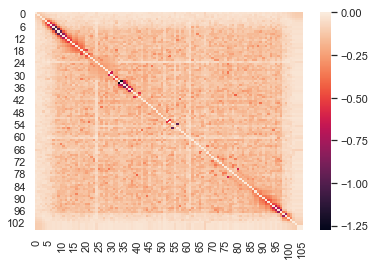

In [3]:
print(len(out) == 9)
print(f'potts model output shape: {out[8].shape}')
print(f'seq_len: {out[8].shape[0]}')
tmp = np.max(np.max(out[8], axis=-1), axis=-1)
sns.heatmap(tmp * -1)
print(f"potts models match: {not bool(np.sum((out[8] == dict_['coevolutionary']) == 0))}")

# Frobenius norm $\left (S_{ij}=\sqrt{\sum^{20}_{a,b=1}\epsilon_{i,j}(a,b)^2} \right)$

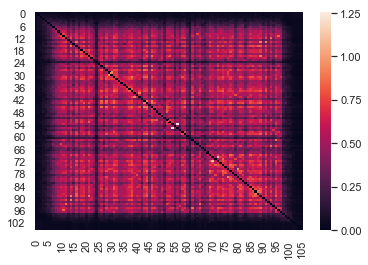

In [4]:
iterator = dataset.make_one_shot_iterator()
frobenius = iterator.get_next()[8]

frobenius = frobenius
frobenius = tf.square(frobenius)
frobenius = tf.reduce_sum(frobenius[:, :, :20, :20], axis=(2, 3))
frobenius = tf.sqrt(frobenius)
frobenius = frobenius - tf.linalg.set_diag(tf.zeros(tf.shape(frobenius)), tf.linalg.diag_part(frobenius))

out = sess.run(frobenius)
sns.heatmap(out)

# APC $\left ( C_{ij}=S_{ij}-\frac{S_{i,}S_{,j}}{S_{,,}} \right )$

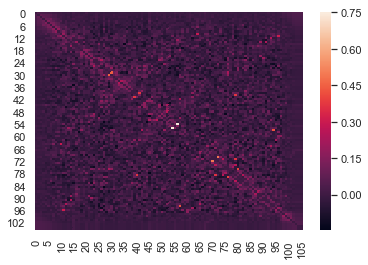

In [5]:
iterator = dataset.make_one_shot_iterator()
frobenius = iterator.get_next()[8]

frobenius = frobenius
frobenius = tf.square(frobenius)
frobenius = tf.reduce_sum(frobenius[:, :, :20, :20], axis=(2, 3))
frobenius = tf.sqrt(frobenius)
frobenius = frobenius - tf.linalg.set_diag(tf.zeros(tf.shape(frobenius)), tf.linalg.diag_part(frobenius))

S_i = tf.reduce_sum(frobenius, (0,))[:, tf.newaxis]
S_j = tf.reduce_sum(frobenius, (1,))[tf.newaxis, :]
S = tf.reduce_sum(frobenius)
apc = frobenius - ((S_i * S_j) / S)
apc = apc - tf.linalg.set_diag(tf.zeros(tf.shape(apc)), tf.linalg.diag_part(apc))

out = sess.run(apc)
sns.heatmap(out)